In [1]:
import matplotlib.pyplot as plt
import numpy as np

'''Функция для отрисовки карты местности с самолётом и аэропортами'''
def drow_map(plane: np.ndarray,
             airoports: np.ndarray,
             direction: float
) -> None:
    abscissa = airoports[:, 0].flatten()
    ordinates = airoports[:, 1].flatten()

    _, axis = plt.subplots(figsize=(9, 9))

    axis.scatter(abscissa, ordinates, c="b", s=30)
    axis.scatter(*plane, marker=(3, 0, direction), c="g", s=200)
    axis.scatter(*plane, marker=(2, 0, direction), c="g", s=200)

    x_rast = 1.1 * np.max(np.abs(abscissa - plane[0]))
    y_rast = 1.1 * np.max(np.abs(ordinates - plane[1]))
    rast = np.max((x_rast, y_rast))

    axis.set_xlim(plane[0] - rast, plane[0] + rast)
    axis.set_ylim(plane[1] - rast, plane[1] + rast)

'''Функция для отрисовки карты местности с самолётом, траекторией его виража и аэропортами'''
def drow_radius(plane: np.ndarray,
                airoports: np.ndarray,
                speed: float,
                direction: float
) -> None:
    abscissa = airoports[:, 0].flatten()
    ordinates = airoports[:, 1].flatten()

    _, axis = plt.subplots(figsize=(9, 9))

    axis.scatter(abscissa, ordinates, c="b", s=30)
    axis.scatter(*plane, marker=(3, 0, direction), c="g", s=200)
    axis.scatter(*plane, marker=(2, 0, direction), c="g", s=200)

    x_rast = 1.1 * np.max(np.abs(abscissa - plane[0]))
    y_rast = 1.1 * np.max(np.abs(ordinates - plane[1]))
    rast = np.max((x_rast, y_rast))

    axis.set_xlim(plane[0] - rast, plane[0] + rast)
    axis.set_ylim(plane[1] - rast, plane[1] + rast)

    #Рассчёт центров кругов траектории виража
    x = np.cos(np.deg2rad(direction))
    y = np.sin(np.deg2rad(direction))
    r = speed ** 2 / (0.00981 * np.deg2rad(20))
    circle1 = plt.Circle((plane[0] + x * r, plane[1] + y * r), r, color='g', alpha=0.3)
    circle2 = plt.Circle((plane[0] - x * r, plane[1] - y * r), r, color='g', alpha=0.3)

    axis.add_patch(circle1)
    axis.add_patch(circle2)

'''Функция рассчёта точек касания окружности и аэропорта,
возвращаемое значение - это массив с координами 2 точек'''
def get_kas_points(circle: np.ndarray,
                   r: float,
                   airoport: np.ndarray
) -> np.ndarray:
    Px, Py = airoport[0], airoport[1]
    Cx, Cy = circle[0], circle[1]

    b = np.sqrt((Px - Cx)**2 + (Py - Cy)**2)  # расстояние между центром и точкой
    th = np.arccos(r / b)  # получение угла между отрезком соединяющим центр и точку и радиусом дл точки касания
    d = np.arctan2(Py - Cy, Px - Cx)  # направление вектора от центра до точки
    d1 = d + th  # направление вектора от центра до первой точки касания
    d2 = d - th  # dнаправление вектора от центра до второй точки касания

    T1x = Cx + r * np.cos(d1)
    T1y = Cy + r * np.sin(d1)
    T2x = Cx + r * np.cos(d2)
    T2y = Cy + r * np.sin(d2)

    return np.vstack((np.array([T1x, T1y]), np.array([T2x, T2y])))

'''Функция для определения оптимального направления виража, 
возвращаемое значение - это координаты центра выбранной траектории виража'''
def choose_circle(plane: np.ndarray,
                  airoport: np.ndarray,
                  speed: float,
                  direction: float
) -> np.ndarray:
    x = np.cos(np.deg2rad(direction))
    y = np.sin(np.deg2rad(direction))
    t = np.tan(np.deg2rad(direction + 90))
    r = speed ** 2 / (0.00981 * np.tan(np.deg2rad(20))) # радиус круга траектории виража

    circle1 = np.array((plane[0] + x * r, plane[1] + y * r)) # координаты центра первого круга траектории виража
    circle2 = np.array((plane[0] - x * r, plane[1] - y * r)) # координаты центра первого круга траектории виража

    # Рассчёт какой из полуплоскостей лежит аэропорт (в поскости с первым центром или вторым)
    if (airoport[1] - (plane[1] + t * (airoport[0] - plane[0]))) * (circle1[1] - (plane[1] + t * (circle1[0] - plane[0]))) >= 0:
        return circle1
    else:
        return circle2

'''Функция для определения верной точки касания, которая соответствует траектории,
возвращаемой значение - это координаты точки конца виража'''
def stop_rotating(plane: np.ndarray,
                  airoport: np.ndarray,
                  speed: float,
                  direction: float
) -> np.ndarray:
    circle = choose_circle(plane, airoport, speed, direction)
    r = speed ** 2 / (0.00981 * np.deg2rad(20))
    points = get_kas_points(circle, r, airoport)
    x = np.cos(np.deg2rad(direction - 90))
    y = np.sin(np.deg2rad(direction - 90))

    # Рассчёт углов между вектором направления полёта и векторами от самолёта до точек касания
    # У нужной нам точки угол будет меньше
    angle1 = np.arccos(np.clip(np.dot(np.array([x, y]), (points[0] - plane) / np.linalg.norm((points[0] - plane))), -1.0, 1.0))
    angle2 = np.arccos(np.clip(np.dot(np.array([x, y]), (points[1] - plane) / np.linalg.norm((points[1] - plane))), -1.0, 1.0))
    if angle1 >= angle2:
        return points[0]
    else:
        return points[1]

'''Функция для определения длины траектории полёта'''
def get_distance(plane: np.ndarray,
                  airoport: np.ndarray,
                  speed: float,
                  direction: float
) -> float:
    point = stop_rotating(plane, airoport, speed, direction)
    x = np.cos(np.deg2rad(direction))
    y = np.sin(np.deg2rad(direction))

    # Угол, который должен пролетель самолёт во время виража
    angle = 2 * np.arccos(np.clip(np.dot(np.array([x, y]), (point - plane) / np.linalg.norm((point - plane))), -1.0, 1.0))

    r = speed ** 2 / (0.00981 * np.deg2rad(20))
    # Длина пути виража и длина от точки конца пути до аэропорта
    dist = 2 * np.pi * r * angle / 360 + np.sqrt(np.sum(np.power(airoport - point, 2)))
    return dist

'''Функция для отрисовки карты местности с самолётом, траекторией его виража и аэропортами,
а также точками которые мы получили в резуьтате выполнения фукций и выделенной ближайшей точкой'''
def test_drow(plane: np.ndarray,
              airoports: np.ndarray,
              speed: float,
              direction: float
) -> None:
    abscissa = airoports[:, 0].flatten()
    ordinates = airoports[:, 1].flatten()

    _, axis = plt.subplots(figsize=(9, 9))

    axis.scatter(abscissa, ordinates, c="b", s=30)
    axis.scatter(*plane, marker=(3, 0, direction), c="g", s=200)
    axis.scatter(*plane, marker=(2, 0, direction), c="g", s=200)

    x_rast = 1.1 * np.max(np.abs(abscissa - plane[0]))
    y_rast = 1.1 * np.max(np.abs(ordinates - plane[1]))
    rast = np.max((x_rast, y_rast))

    axis.set_xlim(plane[0] - rast, plane[0] + rast)
    axis.set_ylim(plane[1] - rast, plane[1] + rast)


    x = np.cos(np.deg2rad(direction))
    y = np.sin(np.deg2rad(direction))
    r = speed ** 2 / (0.00981 * np.deg2rad(20))
    circle1 = plt.Circle((plane[0] + x * r, plane[1] + y * r), r, color='g', alpha=0.3, )
    circle2 = plt.Circle((plane[0] - x * r, plane[1] - y * r), r, color='g', alpha=0.3, )

    axis.add_patch(circle1)
    axis.add_patch(circle2)
    
    mina = 20000**2
    ans = None
    for i in range(airoports.shape[0]):
        if get_distance(plane, airoports[i], speed, direction) < mina:
            mina = get_distance(plane, airoports[i], speed, direction)
            ans = airoports[i]
    
    axis.scatter(*choose_circle(plane, ans, speed, direction), c="r", s=30)

    kax_px = get_kas_points(choose_circle(plane, ans, speed, direction), r, ans)[:, 0]
    kax_py = get_kas_points(choose_circle(plane, ans, speed, direction), r, ans)[:, 1]
    axis.scatter(kax_px, kax_py, c="y", s=30)

    axis.scatter(*stop_rotating(plane, ans, speed, direction), c="black", s=30)
    axis.scatter(*ans, c="purple", s=30)

'''Функция для отрисовки карты местности с самолётом и аэропортами, а также ближайшая точка будет выделена'''
def drow_res(plane: np.ndarray,
             airoports: np.ndarray,
             direction: float,
             winner: np.ndarray = None
) -> None:
    abscissa = airoports[:, 0].flatten()
    ordinates = airoports[:, 1].flatten()

    _, axis = plt.subplots(figsize=(9, 9))

    axis.scatter(abscissa, ordinates, c="b", s=30)
    if not winner is None:
        axis.scatter(*winner, c="y", s=30)
    axis.scatter(*plane, marker=(3, 0, direction), c="g", s=200)
    axis.scatter(*plane, marker=(2, 0, direction), c="g", s=200)

    x_rast = 1.1 * np.max(np.abs(abscissa - plane[0]))
    y_rast = 1.1 * np.max(np.abs(ordinates - plane[1]))
    rast = np.max((x_rast, y_rast))

    axis.set_xlim(plane[0] - rast, plane[0] + rast)
    axis.set_ylim(plane[1] - rast, plane[1] + rast)

Input
94 81
300
716.0 176
3
9 13
57 38
-67 31
Output
57 38
Input
59 -66
119
543.0 175
3
58 54
-47 80
-73 -8
Output
58 54
Input
72 73
108
546.0 180
3
11 -21
76 52
-68 57
Output
76 52
Input
-28 67
259
513.0 199
3
16 -84
-47 -81
82 -34
Output
-47 -81
Input
-32 -80
145
677.0 190
3
-34 96
84 5
-8 -74
Output
-8 -74


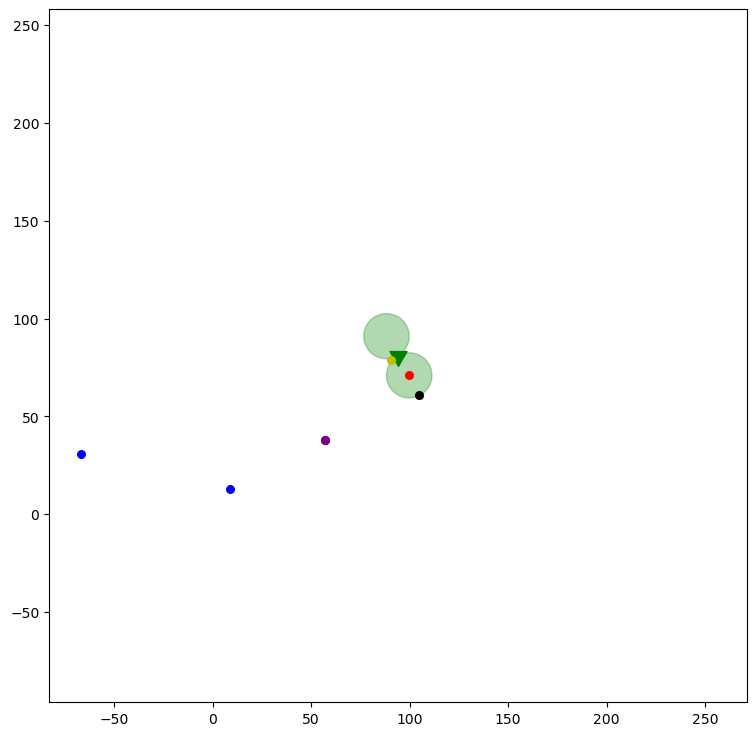

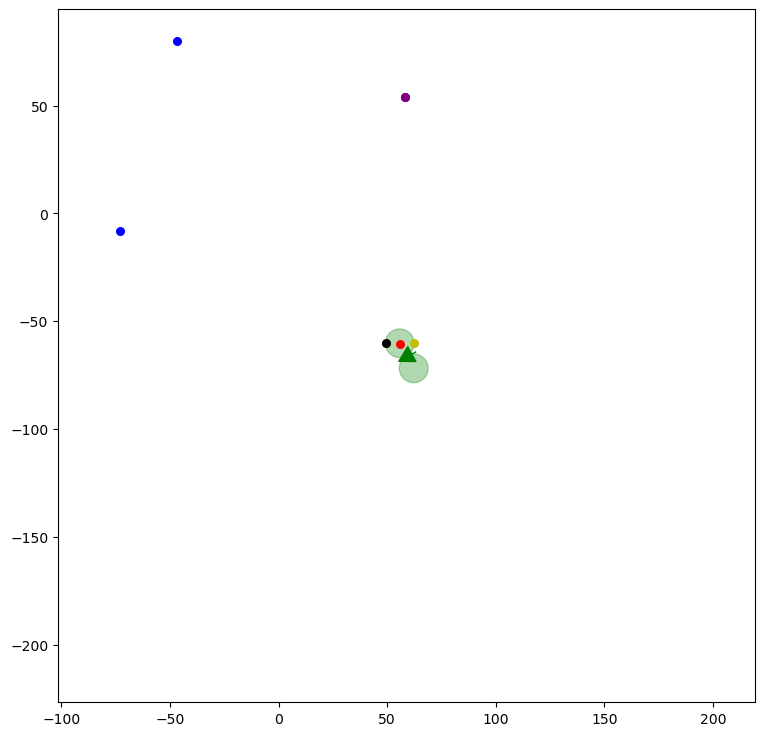

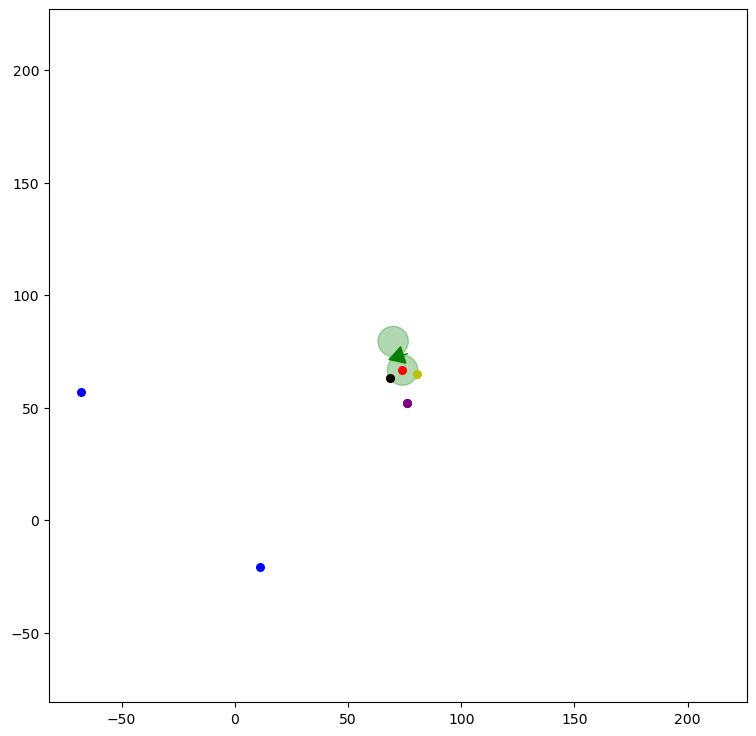

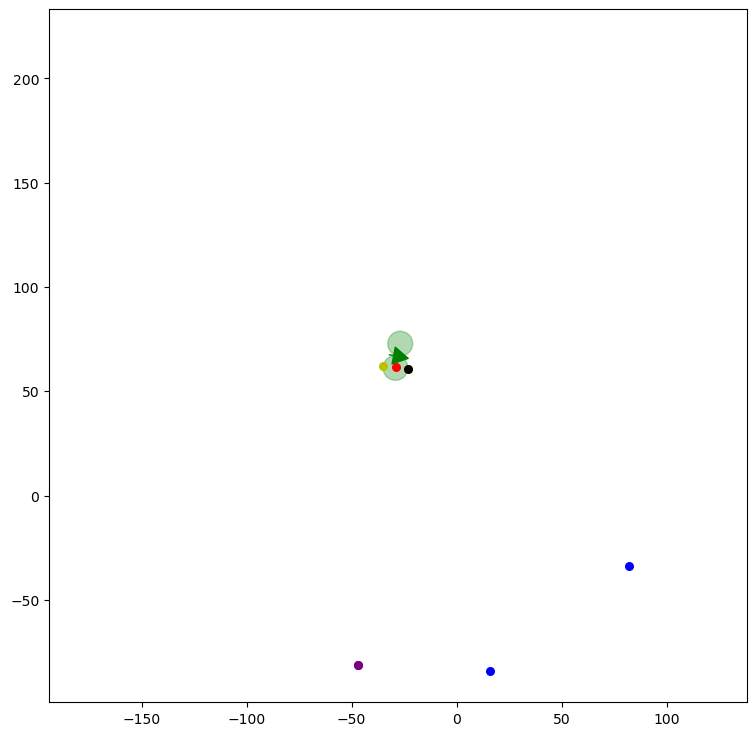

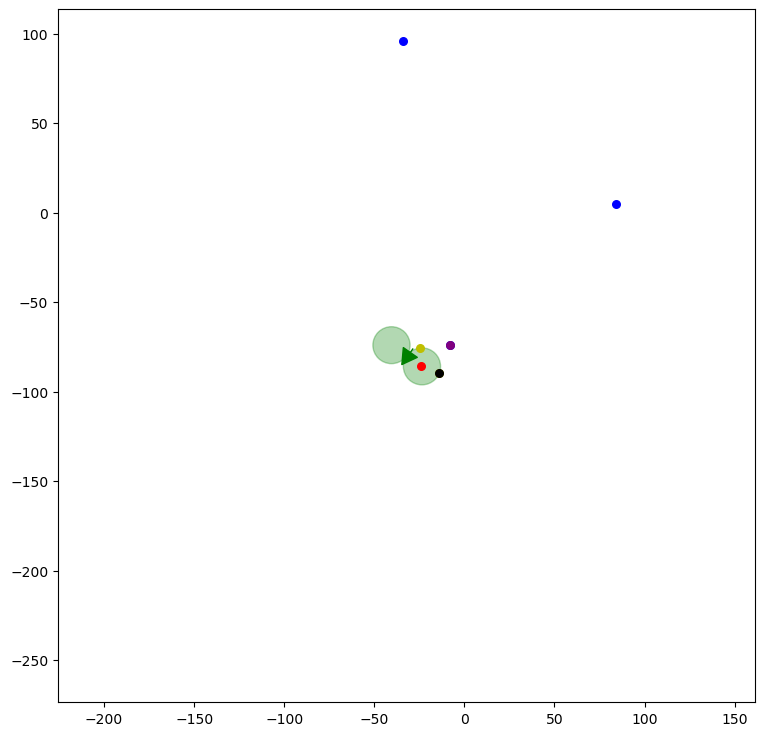

In [6]:
#plane = np.array([0, 0])
#airoports = np.hstack((np.random.randint(-10000, 10000, size=1000)[..., np.newaxis], np.random.randint(-10000, 10000, size=1000)[..., np.newaxis]))
for i in range(5):
    plane = np.array(np.random.randint(-100, 100, size=2))
    direction = np.random.randint(0, 360, size=1)[0]
    speed = np.random.randint(500, 800, size=1)[0] / 3600 
    dist = np.random.randint(150, 200, size=1)[0]
    airoports = np.array([np.random.randint(-100, 100, size=2), np.random.randint(-100, 100, size=2), np.random.randint(-100, 100, size=2)])
    mina = 20000**2
    ans = None
    for i in range(airoports.shape[0]):
        if get_distance(plane, airoports[i], speed, direction) < mina:
            mina = get_distance(plane, airoports[i], speed, direction)
            ans = airoports[i]

    print('Input')
    print(*plane)
    print(direction)
    print(speed * 3600, dist)
    print(3)
    for i in airoports:
        print(*i)
    print("Output")
    if mina <= dist:
        print(*ans)
        #drow_res(plane, airoports, direction, ans)
        test_drow(plane, airoports, speed, direction)
    else:
        print("Критическая ситуация")
        drow_map(plane, airoports, direction)
plt.show()